In [25]:
import numpy as np
import folium
import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import HTML


# 0. General comment:

**For a version of this notebook with displayed maps click this link : ** http://nbviewer.jupyter.org/github/Firas11993/ada2017/blob/master/Homeworks/03%20-%20Interactive%20Viz/Homework3.ipynb

# 1. Unemployment rates in europe :

In [2]:
#Reading the table containing the unemployment rates from 1995 to 2016.
europe_unemployment=pd.read_table('tsdsc330.tsv')
#Keeping only the year 2016 that we need
europe_unemployment_2016=europe_unemployment[['indic_em,age,unit,sex,geo\\time','2016 ']]
#Renaming the column for later use
europe_unemployment_2016=europe_unemployment_2016.rename(columns={'indic_em,age,unit,sex,geo\\time' : 'country'})

In [3]:
europe_unemployment_2016_all_ages=europe_unemployment_2016[europe_unemployment_2016['country'].str.contains('LTU,Y15-74,PC_ACT,T')]
#Extracting country name 
europe_unemployment_2016_all_ages['country']=europe_unemployment_2016_all_ages['country'].apply(lambda x : x.split(',')[4])


/Users/firasbenothman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [4]:
#Reading json files.
path='./topojson/europe.topojson.json'
json_file=json.loads(open(path).read())

#Extracting symbols associated with country name.
symbols=json_file['objects']['europe']['geometries']
symbols=dict([(x['id'],x['properties']['NAME']) for x in symbols])

In [5]:
#Adding country symbols such as it is in the json file.
europe_unemployment_2016_all_ages['country name']=europe_unemployment_2016_all_ages['country'].apply(lambda x : symbols[x] if x in symbols else x)
europe_unemployment_2016_all_ages=europe_unemployment_2016_all_ages.reset_index(drop=True)

/Users/firasbenothman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [6]:
#Changing Great Britain's letters to match the json file
europe_unemployment_2016_all_ages.at[36,'country']='GB'
#Changing Greece's letters to match the json file
europe_unemployment_2016_all_ages.at[11,'country']='GR'

#iceland data unavailable so it was dropped
europe_unemployment_2016_all_ages=europe_unemployment_2016_all_ages.drop(20)

#Denmark's unemployment rate written in a weird way
europe_unemployment_2016_all_ages.at[7,'2016 ']=1.4

europe_unemployment_2016_all_ages['2016 ']=europe_unemployment_2016_all_ages['2016 '].apply(lambda x :float(x) )
europe_unemployment_2016_all_ages=europe_unemployment_2016_all_ages.reset_index(drop=True)

Inorder to make the choropleth as clear as possible, we need to choose the thresholds in a way that makes the countries with distant unemployment rates obviously different on the map. For instance, the unemployment rate in Italy is 6.7% and in spain it is 9.5%, the difference is quite noticeable so the colours of these countries maps must be different too. 

After exploring the dataset, this is how we chose the thresholds :

- We see that there are quite a few countries with a quite low unemployment rate of under 2%, so that will be our second threshold, right after 0%. 

- Then most countries are a little more than 2% then a jump to 4%, so 4 will be our second threshold.

- between 4% and 6% the unemployment rates are a somewhat close together ==> 6% : third threshold

- Then there are countries with a relatively high unemployment rates, such as Portugal, Italy, which are still less than 7% ==> /7% is the next threshold.

- All the countries left have unemployment rates of almost 10% to waay over 10% which are all high unemployment rates. However, there is a significant difference between Spain : 9.5% and Greece 17.0%, which is why our final threshold is 17%.

In [7]:
europe_map = folium.Map(location=[51.516, 9.9], zoom_start=3.5)
europe_map.choropleth(geo_data=json_file, topojson='objects.europe', data=europe_unemployment_2016_all_ages,
             columns=['country', '2016 '],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2, threshold_scale=[0,2,4,6,7,17],
             legend_name='Unemployment Rate for ages between 15 and 74 (%)')
europe_map

Switzerland's unemployment rate is quite low compared to the rest of europe. It's in same unemployment rate range as Germany, Norway ,the United Kingdom and so on... that have low unemployment rates in 2016.

In [8]:
#Saving the map
europe_map.save('europe_unemployment_2016.html')

# 2. Exploring Swiss Dataset : 

In [9]:
#Reading the swiss cantons dataset
swiss_dataset=pd.read_table('./2_1 Taux de chômage.txt',skiprows=[1],delimiter=',',usecols=['Canton','Septembre 2017'])

In [10]:
swiss_json_path='./topojson/ch-cantons.topojson.json'
swiss_json_file=json.loads(open(swiss_json_path).read())

In [11]:
#Extracting Canton symbols from json file
canton_symbols=dict()
data=swiss_json_file['objects']['cantons']['geometries']
for i in range(len(data)):
    id_=data[i]['id']
    name_=data[i]['properties']['name']
    canton_symbols[name_]=id_

In [12]:
#The names of the cantons are written differently but fortunately they are sorted the same way in the dataset as in the json file

#Dropping the row showing the totals.
swiss_dataset=swiss_dataset.drop(26)

#Creating a new column for canton symbols
swiss_dataset['symbols']=list(canton_symbols)
#Replacing canton names by their respective two letter symbol
swiss_dataset['symbols']=swiss_dataset['symbols'].apply(lambda x : canton_symbols[x])

The unemployment rates in swiss cantons are between 0.6% and 5.2%, without any significant jumps in unemployment rates. Which is why, we decided to make thresholds of {0,1,2,3,4,5} which shows the difference between, for instance, Geneva (5.2%) and Vaud (4.3%), and, Vaud (4.3%) and Zurich (3.3%).

In [13]:
swiss_map = folium.Map(location=[46.818188, 8.227512], zoom_start=8)
swiss_map.choropleth(geo_data=swiss_json_file, topojson='objects.cantons', data=swiss_dataset,
             columns=['symbols', 'Septembre 2017'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2, threshold_scale=[0,1, 2, 3,4,5],
             legend_name='Unemployment Rate for ages between 15 and 74 (%)')
swiss_map

In [14]:
#Saving the map
swiss_map.save('swiss_unemployment_2017.html')

# 3. Exploring unemployment amongst foreigners:

## Choropleths :

In [15]:
#Uploading the dataset
swiss_foreign_dataset=pd.read_table('./2_1 Taux de chômage_par_nationalite.txt',delimiter=',',skiprows=[0],usecols=['Canton','Nationalité','Septembre 2017']).drop([0,53])

In [16]:
#Extracting foreigners unemployment and swiss unemployment datasets
swiss_unemployment=swiss_foreign_dataset[swiss_foreign_dataset['Nationalité'].str.contains('Suisses')]
foreign_unemployment=swiss_foreign_dataset[swiss_foreign_dataset['Nationalité'].str.contains('Etrangers')]

#Creating a new column for canton symbols.
swiss_unemployment['symbols']=list(canton_symbols)
foreign_unemployment['symbols']=list(canton_symbols)

#Replacing canton names by their respective two letter symbol.
swiss_unemployment['symbols']=swiss_unemployment['symbols'].apply(lambda x : canton_symbols[x])
foreign_unemployment['symbols']=foreign_unemployment['symbols'].apply(lambda x : canton_symbols[x])

#Casting strings to floats for computations.
swiss_unemployment['Septembre 2017']=swiss_unemployment['Septembre 2017'].apply(lambda x : float(x))
foreign_unemployment['Septembre 2017']=foreign_unemployment['Septembre 2017'].apply(lambda x : float(x))


/Users/firasbenothman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/firasbenothman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/firasbenothman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

** Unemployment rates difference representation : **
To show the differences in each Canton between foreign and swiss unemployment rates, we use layers.

It is enough to select the right layer to see the choropleth of the unemployment of the Swiss or foreigners.

To clearly see the difference, we keep the thresholds the same and the colours the same.

In [17]:
s_map = folium.Map(location=[46.818188, 8.227512], zoom_start=8)
s_map.choropleth(geo_data=swiss_json_file, topojson='objects.cantons', data=swiss_unemployment,
             columns=['symbols', 'Septembre 2017'],
             key_on='feature.id',
             name='Swiss',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2, threshold_scale=[0,2,3,4,5,7],
             legend_name='Unemployment Rate for the Swiss with ages between 15 and 74 (%)')
s_map.choropleth(geo_data=swiss_json_file, topojson='objects.cantons', data=foreign_unemployment,
             columns=['symbols', 'Septembre 2017'],
             key_on='feature.id',
             name='Foreign',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2, threshold_scale=[0,2,3,4,5,7],
             legend_name='Unemployment Rate for foreigns in Switzerland ages between 15 and 74 (%)')
folium.LayerControl().add_to(s_map)

s_map

The unemployment rate difference between locals and foreigners is very clear on the choropleth.

The rate is higher for foreigner in almost all the cantons.

It is especially the case with cantons that typically host many foreigners, such as, Zurich, berne, Vaud and so on...

In [18]:
#Saving the map
s_map.save('Swiss_foreigner_unemployment_2017.html')

## Bar Plots :

In [19]:
age_group_unemployment=pd.read_table('./1_1 Chômeurs et demandeurs d_emploi selon divers critères.txt',skiprows=[0],usecols=[0,1,2,5],delimiter=',').drop(0)

In [20]:
#Helper function to avoid code repetition.
def getCategoryDataFrame(dataframe, age_group, nationality):
    #Prevent misuse of the function.
    if(nationality not in ['Etrangers','Suisses'] or age_group not in [1,2,3]) : raise ValueError('Invalid parameter')
    else : 
        new_frame= dataframe[dataframe["Classes d'âge 15-24"].str.contains(str(age_group))]
        new_frame= new_frame[new_frame["Nationalité"].str.contains(nationality)]
        
        #Casting unemployment number to float for later use.
        new_frame['Unemployed number']=new_frame['Unemployed number'].apply(lambda x : float(x.replace("'","")))

        return new_frame

In [21]:
age_group_unemployment=age_group_unemployment.rename(columns={'Unnamed: 5':'Unemployed number'}).dropna()

#Exctracting the useful dataframes for the bar plots and casting numbers to floats.

#Foreigners dataframes
foreign_15_24_group_unemployment=getCategoryDataFrame(age_group_unemployment,1,'Etrangers')
foreign_25_49_group_unemployment=getCategoryDataFrame(age_group_unemployment,2,'Etrangers')
foreign_over_50_group_unemployment=getCategoryDataFrame(age_group_unemployment,3,'Etrangers')

#Swiss dataframes
swiss_15_24_group_unemployment=getCategoryDataFrame(age_group_unemployment,1,'Suisses')
swiss_25_49_group_unemployment=getCategoryDataFrame(age_group_unemployment,2,'Suisses')
swiss_over_50_group_unemployment=getCategoryDataFrame(age_group_unemployment,3,'Suisses')


## Plots for age group 1 : 

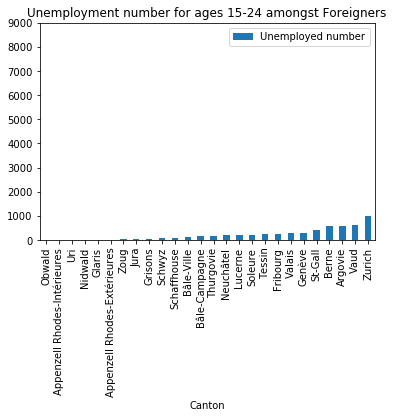

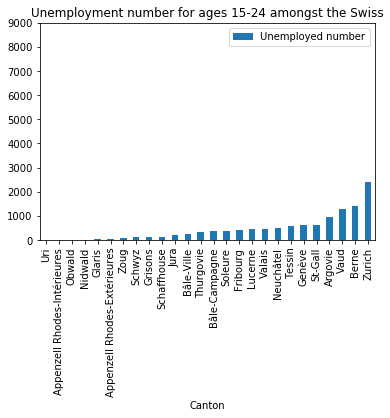

In [22]:
plt1=foreign_15_24_group_unemployment.sort_values(by='Unemployed number').plot(
    kind='bar', x='Canton',title='Unemployment number for ages 15-24 amongst Foreigners')
plt1.set_ylim(0,9000)

plt4=swiss_15_24_group_unemployment.sort_values(by='Unemployed number').plot(
    kind='bar', x='Canton',title='Unemployment number for ages 15-24 amongst the Swiss')
plt4.set_ylim(0,9000)

plt.show()

## Plots for age group 2 :

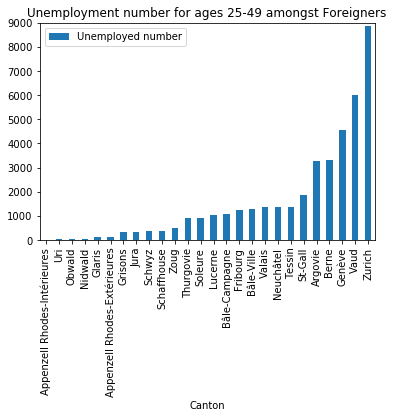

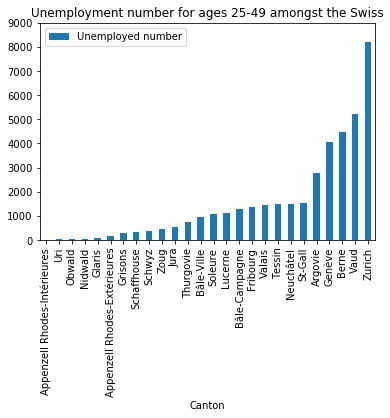

In [23]:
plt2=foreign_25_49_group_unemployment.sort_values(by='Unemployed number').plot(
    kind='bar', x='Canton',title='Unemployment number for ages 25-49 amongst Foreigners')
plt2.set_ylim(0,9000)

plt5=swiss_25_49_group_unemployment.sort_values(by='Unemployed number').plot(
    kind='bar', x='Canton',title='Unemployment number for ages 25-49 amongst the Swiss')
plt5.set_ylim(0,9000)
plt.show()

## Plots for age group 3

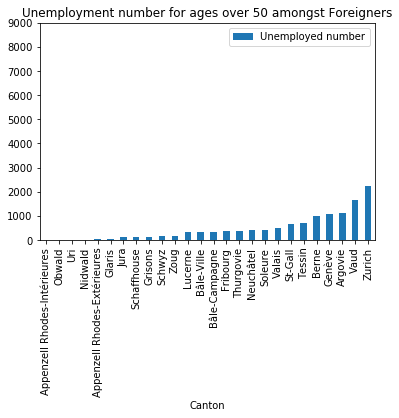

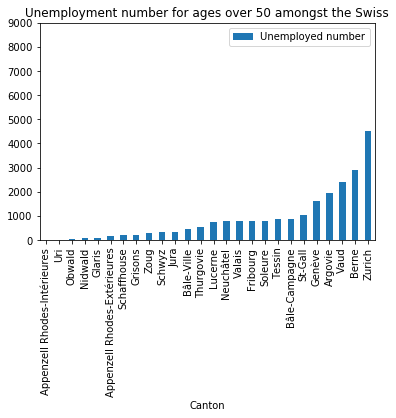

In [24]:
plt3=foreign_over_50_group_unemployment.sort_values(by='Unemployed number').plot(
    kind='bar', x='Canton',title='Unemployment number for ages over 50 amongst Foreigners')
plt3.set_ylim(0,9000)

plt6=swiss_over_50_group_unemployment.sort_values(by='Unemployed number').plot(
    kind='bar', x='Canton',title='Unemployment number for ages over 50 amongst the Swiss')
plt6.set_ylim(0,9000)


plt.show()

As we can see from the bar plots:

- for age group 1 (ages in 15-24), there seems to be overall more registered unemployed among the Swiss than among foreigners.

- for age group 2 (ages in 25-49), there seems to be, overall, significantly more foreigners unemployed than Swiss ones in the cantons with high unemployed population (Zurich, Berne, Vaud...). However, the numbers are pretty comparable for other cantons.

- for age group 3 (over 50), there are overall more Swiss unemplyed than foreign ones. This could be explained by the high number of older citizens in Switzerland compared to immigrants.